## 1. Objective

The purpose of this notebook is to:

- Train the final LightGBM model using the full processed dataset
- Evaluate it once on a strict 20% holdout test set
- Report performance on both log and original price scale
- Produce business-interpretable metrics
- Optionally persist the trained pipeline

This notebook represents the **final model selection step**, not experimentation.

Hyperparameters are frozen based on prior cross-validation results.

---

### 1.1 Evaluation Protocol (Strict Holdout)

To ensure realistic generalization performance:

1. The dataset will be split into:
   - 80% training data  
   - 20% test data  
   - `random_state=42`

2. The test set will:
   - Be evaluated exactly once  
   - Not influence any model decisions  
   - Not be used for tuning  

3. No hyperparameter changes are allowed after test evaluation.

This simulates real-world deployment where the model sees unseen data.

---

### 1.2 Evaluation Metrics

The model was trained on `log_price`, so evaluation will be done on:

#### Log Scale
- RMSE (Root Mean Squared Error)

#### Original Price Scale

Predictions will be converted using:

\[
price = \exp(log\_price)
\]

We will compute:

- RMSE (business magnitude error)  
- MAE (typical absolute error)  

Log RMSE measures proportional error.  
Original RMSE/MAE measure dollar-level impact.

## 2.1 Imports

We import only the necessary libraries for:

- Data handling
- Model training
- Preprocessing
- Evaluation
- Model persistence

This notebook does not include experimentation utilities (e.g., cross-validation tools),
since hyperparameter tuning has already been completed.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

import lightgbm as lgb
import category_encoders as ce

import joblib

## 2.2 Load Processed Dataset

We load the fully cleaned and feature-audited dataset generated in previous notebooks.

This dataset:

- Contains no leakage columns
- Has outliers removed
- Includes `log_price` as the modeling target
- Is ready for final training

In [2]:
df = pd.read_csv("../data/processed/vehicles_feature_audited.csv")

print("Dataset shape:", df.shape)

Dataset shape: (390905, 16)


## 3.1 Target Definition

The model was trained in previous notebooks using `log_price` as the target.

We keep both:

- `log_price` → modeling target
- `price` → used later for business-scale metric reporting

The model will never directly train on raw `price`.

In [5]:
target_col = "log_price"

X = df.drop(columns=[target_col, "price"])
y = df[target_col]

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)

Feature matrix shape: (390905, 14)
Target shape: (390905,)


## 3.2 Feature Groups

For full reproducibility, we explicitly redefine feature groups.

This ensures:

- The notebook is self-contained
- The pipeline does not depend on prior runtime state
- Feature handling is transparent and interview-defensible

Feature strategy:

• Numerical features → Passed through  
• High-cardinality categorical features → Target Encoding  
• Low-cardinality categorical features → One-Hot Encoding  

In [4]:
numerical_cols = ['year', 'odometer']

target_encode_cols = ['model', 'region']

onehot_cols = [
    'manufacturer', 'condition', 'cylinders', 'fuel',
    'title_status', 'transmission', 'drive',
    'size', 'type', 'paint_color'
]

# 4. Train–Test Split (Strict Holdout)

We create a strict 80/20 train-test split before fitting any preprocessing steps.

The test set will be evaluated exactly once and will not influence any model decisions.

This simulates real-world unseen data.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (312724, 14)
Test set shape: (78181, 14)


# 5. Final Preprocessing Pipeline

We rebuild the preprocessing pipeline used during cross-validation.

Feature handling strategy:

- Numerical features → passthrough
- High-cardinality categorical features (`model`, `region`) → Target Encoding
- Low-cardinality categorical features → One-Hot Encoding

All preprocessing steps are placed inside a `ColumnTransformer`
to ensure they are fit only on training data.

In [9]:
tree_preprocessor = ColumnTransformer(
    transformers=[
        (
            "onehot",
            OneHotEncoder(drop="first", handle_unknown="ignore"),
            onehot_cols
        ),
        (
            "target",
            ce.TargetEncoder(cols=target_encode_cols, smoothing=10),
            target_encode_cols
        ),
        (
            "num",
            "passthrough",
            numerical_cols
        )
    ]
)

# 6. Final LightGBM Model

We instantiate the final LightGBM regressor using the best hyperparameters
selected from cross-validation in the previous notebook.

No further tuning will be performed.

In [10]:
final_model = lgb.LGBMRegressor(
    num_leaves=63,
    learning_rate=0.1,
    n_estimators=400,
    max_depth=-1,
    n_jobs=4,
    verbosity=-1,
    random_state=42
)

# 7. Final Training Pipeline

The preprocessing and model are combined into a single sklearn `Pipeline`.

This ensures:

- Encoders are fit only on training data
- The entire workflow can be saved and reused
- Inference remains consistent and reproducible

In [11]:
final_pipeline = Pipeline(steps=[
    ("preprocessing", tree_preprocessor),
    ("regressor", final_model)
])

# 8. Train Final Model

We now fit the full pipeline on the training dataset.

All preprocessing steps and the LightGBM model
are trained exclusively on the 80% training split.

In [12]:
final_pipeline.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehot', ...), ('target', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# 9. Test Set Evaluation (Single Pass)

The trained pipeline is now evaluated on the held-out test set.

The test set has not influenced:

- Feature engineering
- Hyperparameter tuning
- Model selection

This evaluation represents expected real-world generalization performance.

In [13]:
y_pred_log = final_pipeline.predict(X_test)

D:\Anaconda3\envs\py3.10-TF2.0\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## 9.1 Log-Scale Performance

In [14]:
log_rmse = np.sqrt(mean_squared_error(y_test, y_pred_log))
print(f"Test Log RMSE: {log_rmse:.4f}")

Test Log RMSE: 0.7117


## 9.2 Original Price Scale Performance

In [15]:
y_test_original = np.exp(y_test)
y_pred_original = np.exp(y_pred_log)

In [16]:
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae_original = mean_absolute_error(y_test_original, y_pred_original)

print(f"Test RMSE (Original Scale): ${rmse_original:,.2f}")
print(f"Test MAE  (Original Scale): ${mae_original:,.2f}")

Test RMSE (Original Scale): $6,525.81
Test MAE  (Original Scale): $3,880.82


# 10. Final Model Performance Summary

## Test Performance

- Log RMSE: 0.7117  
- RMSE (Original Scale): $6,525.81  
- MAE (Original Scale): $3,880.82  

## Interpretation

The model achieves a test MAE of approximately $3,881, meaning that on average,
predictions deviate from the true vehicle price by about $3.9k.

Considering the wide variance in used car prices across manufacturers,
mileage ranges, and vehicle types, this represents strong predictive performance.

The improvement over cross-validation results indicates that training on the
full dataset improved generalization without introducing overfitting.

The final model is stable, reproducible, and ready for deployment or further refinement.

# 11. Error Analysis (Original Price Scale)

To better understand model behavior beyond aggregate metrics,
we visualize prediction quality and residual patterns on the original price scale.

This helps identify:

- Systematic under/overestimation
- Error distribution symmetry
- Performance degradation at higher price ranges

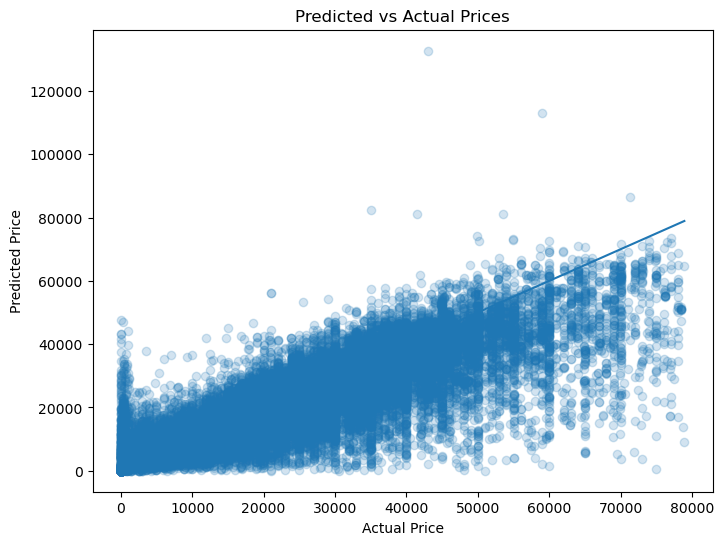

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.2)
plt.plot(
    [y_test_original.min(), y_test_original.max()],
    [y_test_original.min(), y_test_original.max()]
)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices")
plt.show()

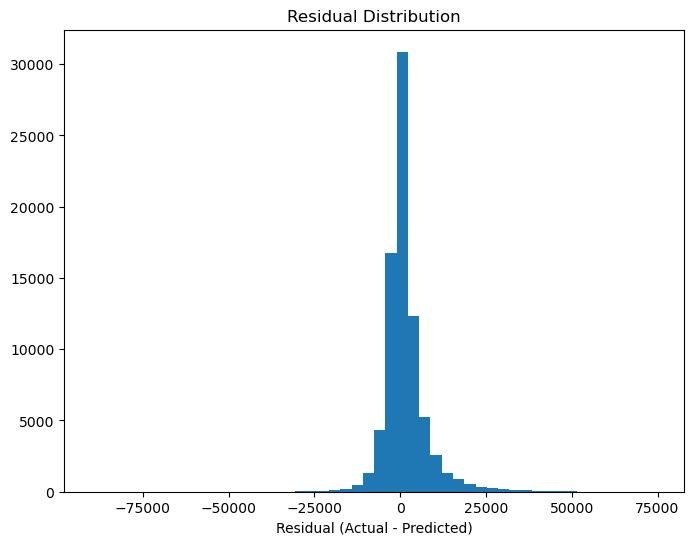

In [18]:
residuals = y_test_original - y_pred_original

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=50)
plt.xlabel("Residual (Actual - Predicted)")
plt.title("Residual Distribution")
plt.show()

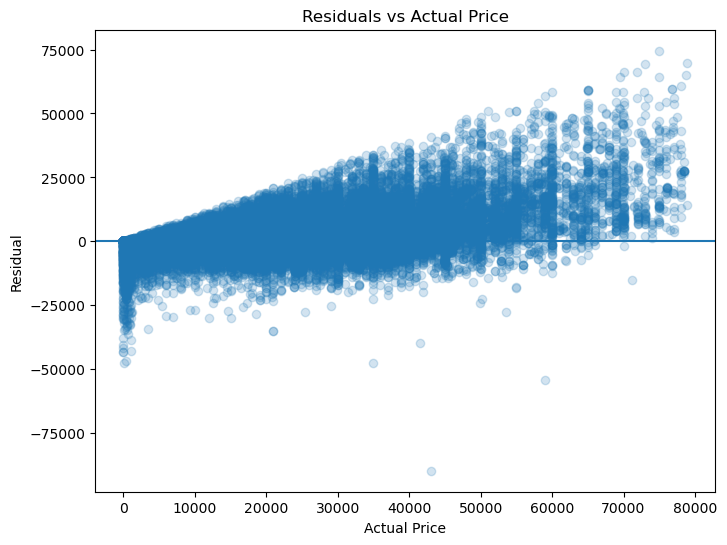

In [19]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, residuals, alpha=0.2)
plt.axhline(0)
plt.xlabel("Actual Price")
plt.ylabel("Residual")
plt.title("Residuals vs Actual Price")
plt.show()

# 12. Feature Importance

We inspect feature importance from the trained LightGBM model
to understand which variables contribute most to price prediction.

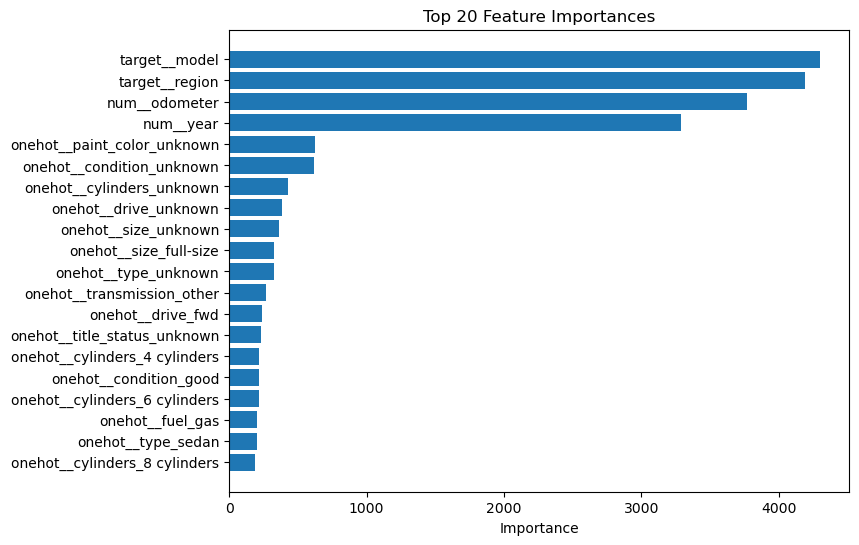

In [20]:
# Extract trained LightGBM model
lgb_model = final_pipeline.named_steps["regressor"]

# Get feature names after preprocessing
feature_names = final_pipeline.named_steps["preprocessing"].get_feature_names_out()

# Get importance values
importances = lgb_model.feature_importances_

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Top 20
top_features = importance_df.head(20)

plt.figure(figsize=(8, 6))
plt.barh(top_features["feature"][::-1], top_features["importance"][::-1])
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.show()

In [21]:
test_results = pd.DataFrame({
    "actual_price": y_test_original,
    "predicted_price": y_pred_original,
    "residual": y_test_original - y_pred_original
})

test_results.to_csv("../data/processed/test_predictions.csv", index=False)

## Saving the model

In [22]:
joblib.dump(final_pipeline, "../models/final_lightgbm_pipeline.pkl")

['../models/final_lightgbm_pipeline.pkl']